# Make Non-Uniform Sparse Data Maps In Python

Lately, I have been working with gridded data sets. Climate scientists and oceanographers have been fervently creating gridded data sets using satellite and in situ data that are released. For example, see the [Argo gridded product page](https://argo.ucsd.edu/data/argo-data-products/) for ocean grids, [Here for precipitation](https://gpm.nasa.gov/data). There is also vector grids available for wind [CCMP Wind Vector Analysis Product](http://www.remss.com/measurements/ccmp/). [The Interactive Multisensor Snow and Ice Mapping System (IMS)](https://www.natice.noaa.gov/ims/) is another great example. 

Grids do not have to be global such as the [Southern Ocean State Estimate (IMS)](http://sose.ucsd.edu/).

I am working on making a [gridded product](https://www.itsonlyamodel.us/mle-gradient-derivation.html).

Gridded data is usually saved as TIFF files and there are many tools available to work with these images. However, TIFF files assume the gridded data is uniform, that the latitude spaces are all the same as longitude. the IMS and SOSE grids are not non-uniform and have to be re-gridded (interpolated on a uniform grid). 

## Argovis grid module

[Argovis](https://argovis.colorado.edu/ng/grid?presLevel=0&date=2013-01-01&shapes=%5B%5B-40,-70,0,-30%5D%5D&gridName=sose_si_area_1_day_sparse&interpolateBool=false&colorScale=ice&inverseColorScale=false&paramMode=false&param=SIarea&gridDomain=%5B0,0.82%5D) has visualization and data delivery capabilities for a few of gridded products, Including SOSE Sea-Ice coverage percentage, shown below.

![alt text](sssi.jpg)

There is very little ice in the domain covered by SOSE, making this dataset sparse. The MongoDB database stores the data for only grid cells that contain sea-ice, making the data payload $\frac{1}{5}$ the size otherwise. Visualizing the grid on Argovis requires the grid to be de-sparsed and re-gridded to be uniform rectangular. The Leaflet map uses the [Leaflet CanvasLayer](https://github.com/tylertucker202/Leaflet.CanvasLayer.Field) plugin. This plugin extends the leaflet map to include HTML canvas elements of uniform gridded data.

## Implementation of Regridding

I am going to show you how gridded data is output the MongoDB, and how the front end charts the non-uniform data on Argovis. Although Argovis implements this using Typescript, this notebook uses Python. The process is identical.

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from scipy import interpolate
import itertools
import pdb
import cartopy.crs as ccrs

1. We make two API calls. One is for the sparse data, the other is for the grid points falling within the lat-lon window. The function calls to the API below. By the way, I wrote this [API documentation](https://argovis.colorado.edu/api-docs/) using swagger. You can see in more detail what each API call outputs. Swagger gives examples, and even lets you make API calls of your own!

In [2]:
def get_grid(gridName, latRange, lonRange, date, presLevel):
    url = 'https://argovis.colorado.edu/griddedProducts/nonUniformGrid/window?'
    url += 'gridName={}'.format(gridName)
    url += '&presLevel={}'.format(presLevel)
    url += '&date={}'.format(date)
    url += '&latRange={}'.format(latRange)
    url += '&lonRange={}'.format(lonRange)
    url = url.replace(' ', '')
    # Consider any status other than 2xx an error
    print(url)
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    grid = resp.json()
    return grid[0]

def get_grid_coords(gridName, latRange, lonRange):
    url = 'https://argovis.colorado.edu/griddedProducts/gridCoords?'
    url += 'gridName={}'.format(gridName)
    url += '&latRange={}'.format(latRange)
    url += '&lonRange={}'.format(lonRange)
    url = url.replace(' ', '')
    # Consider any status other than 2xx an error
    print(url)
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    grid = resp.json()
    return grid[0]    

In [3]:
latRange=[-70, -65]
lonRange=[0, 40]
gridName='sose_si_area_1_day_sparse'
date='2013-01-04'
presLevel=0
grid = get_grid(gridName, latRange, lonRange, date, presLevel)
gridCoords = get_grid_coords(gridName, latRange, lonRange)

https://argovis.colorado.edu/griddedProducts/nonUniformGrid/window?gridName=sose_si_area_1_day_sparse&presLevel=0&date=2013-01-04&latRange=[-70,-65]&lonRange=[0,40]
https://argovis.colorado.edu/griddedProducts/gridCoords?gridName=sose_si_area_1_day_sparse&latRange=[-70,-65]&lonRange=[0,40]


2. We define our uniform grid. We space it horizontally by $\frac{1}{4}$ and vertically by $\frac{1}{2}$. 

In [4]:
lats = np.array(gridCoords['lats'])
lons = np.array(gridCoords['lons'])
dx, dy = .25, .5
x = np.arange(min(lons), max(lons), dx)
y = np.arange(min(lats), max(lats), dy)
xi, yi = np.meshgrid(x, y)

3. Desparse the non-uniform grid. Remember we interpolate our uniform grid with coordinates. 

In [5]:
xv, yv = np.meshgrid(lons, lats)
ice = np.zeros(xv.shape)
lngLat = []
vals = []
for row in grid['data']:
    lat_idx = np.where(lats == row['lat'])
    lon_idx = np.where(lons == row['lon'])
    ice[lat_idx, lon_idx] = row['value']
    lngLat.append((row['lon'], row['lat']))
    vals.append(row['value'])

4. Interpolate the de-sparsed grid onto the uniform grid. 

Some thought needs to go into how we interpolate. We can 'cheat' by using Scipy's interpolate function. Interpolate uses Delaunay triangles to create a mesh and interpolates based on this mesh. The source code points to a class [LinearNDInterpolator](https://github.com/scipy/scipy/blob/v1.5.2/scipy/interpolate/interpnd.pyx) that uses [Qhull](http://www.qhull.org/). If we were to do this on the front end, we would have to write this routine in Typescript. Instead, I wrote a simpler algorithm that takes advantage of the rectangular structure of our grid. We will compare the two.

In [6]:
grid_cheat = griddata(lngLat, vals, (xi, yi), method='linear')

Our algorithm uses a nearest neighbor binary solver. Each interpolated point searches for the four surrounding points of the non-uniform grid and does a bilinear interpolation.

In [7]:
def find_closest_idx(arr, target):
    arrLen = len(arr)
    # Corner cases 
    if (target <= arr[0]): 
        return (0, 1)
    if (target >= arr[arrLen - 1]): 
        return [arrLen - 1, -1]

    # Doing iterative binary search 
    idx = 0; jdx = arrLen-1; mid = 0
    while (idx < jdx):  
        mid = int((idx + jdx) / 2)

        if (arr[mid] == target): # target is midpoint
            return (mid, 1)
        if (arr[idx] == target): #target is left edge
            return (idx, 1)
        

        if (target < arr[mid]): # search to the left of mid
            # If target is greater than previous 
            # to mid, return closest of two 
            if (mid > 0 and target > arr[mid - 1]):
                return get_closest_idx(arr[mid - 1], arr[mid], mid-1, target) 
            # Repeat for left half  
            jdx = mid 

        else: # search to the right of mid
            if (mid < arrLen - 1 and target < arr[mid + 1]): 
                return get_closest_idx(arr[mid], arr[mid+1], mid, target) 
            idx = mid + 1
    # Only single element left after search 
    return [mid, 1] 

def get_closest_idx(val1, val2, val1_idx, target): 
    if (target - val1 >= val2 - target): 
        return (val1_idx+1, -1)
    else: 
        return (val1_idx, 1)

Here is an example that shows what is going on for a single interpolation point.

In [8]:
iPoint = (14, -68.7777) # Example interpolation point
def find_surrounding_points(iPoint, print_me=False):
    lat_idx, lat_shift = find_closest_idx(lats, iPoint[1])
    lon_idx, lon_shift = find_closest_idx(lons, iPoint[0])
    llPoint = (lons[lon_idx], lats[lat_idx], ice[lat_idx, lon_idx])
    lrPoint = (lons[lon_idx+lon_shift], lats[lat_idx], ice[lat_idx, lon_idx+lon_shift])
    urPoint = (lons[lon_idx+lon_shift], lats[lat_idx+lat_shift], ice[lat_idx+lat_shift, lon_idx+lon_shift])
    ulPoint = (lons[lon_idx], lats[lat_idx+lat_shift], ice[lat_idx+lat_shift, lon_idx])
    points = [llPoint, lrPoint, urPoint, ulPoint]
    if print_me:
        print(f'interpolated point: {iPoint}')
        print(f'lat_idx: {lat_idx}, lon_idx: {lon_idx}')
        print(f'lats[lat_idx]: {lats[lat_idx]}, lons[lon_idx]: {lons[lon_idx]}')
        print(f'lats[lat_idx+lat_shift]: {lats[lat_idx+lat_shift]}, lons[lon_idx+lon_shift]: {lons[lon_idx + lon_shift]}')
    x, y = [point[0] for point in points], [point[1] for point in points]
    return (points, (x, y))

points, (x, y) = find_surrounding_points(iPoint, True)

interpolated point: (14, -68.7777)
lat_idx: 20, lon_idx: 84
lats[lat_idx]: -68.79, lons[lon_idx]: 14.083
lats[lat_idx+lat_shift]: -68.73, lons[lon_idx+lon_shift]: 13.917


Below is a diagram of the points found by the nearest neighbor algorithm.

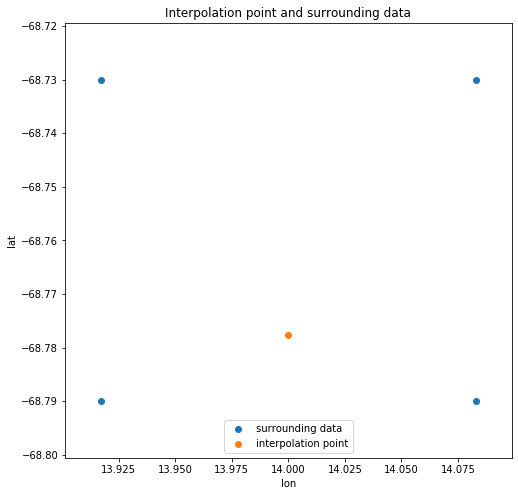

In [9]:
def plot_interpolation_point(x, y, iPoint, loc="lower center"):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.scatter(x, y, label='surrounding data')
    ax.scatter(iPoint[0], iPoint[1], label='interpolation point')
    ax.set_title('Interpolation point and surrounding data')
    ax.set_ylabel('lat')
    ax.set_xlabel('lon')
    ax.legend(loc=loc)
    
plot_interpolation_point(x, y, iPoint)

Our interpolation point (orange) lies on or within our non-uniform grid points (blue). The bilinear interpolation function is as follows.

In [10]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

print(bilinear_interpolation(iPoint[0], iPoint[1], points))

0.6003710595517789


In [11]:
iPoints = [ (xi.flatten()[idx], yi.flatten()[idx]) for idx in range(len(xi.flatten()))]
iGrid = []
for iPoint in iPoints:
    points, (_, _) = find_surrounding_points(iPoint)
    iVal = bilinear_interpolation(iPoint[0], iPoint[1], points)
    iGrid.append(iVal)
    
iGrid = np.array(iGrid).reshape(xi.shape)

In [13]:
iGrid.shape

(10, 160)

## Comparison

Our Algorithm follows the ocean contours rather well, yet there is still some overlap. A land mask would help prevent this grid from reporting ice on land. See the map below.

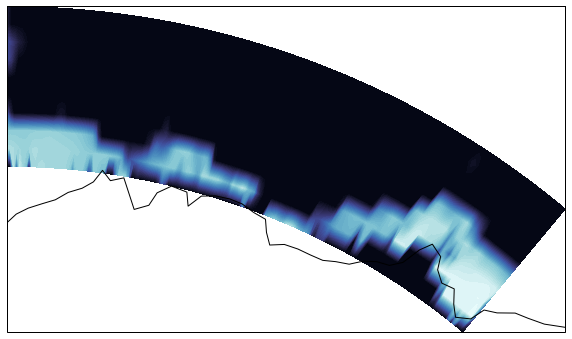

In [12]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=-90)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=map_proj)
ax.contourf(xi, yi, iGrid, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
ax.coastlines()

Scipy's interpolation reports ice over sea regions where there should not be any, as seen by the lighter blue 'fingers' in the figure below. Delaunay triangles are connecting ice sheets that do not reflect what the data reports. 

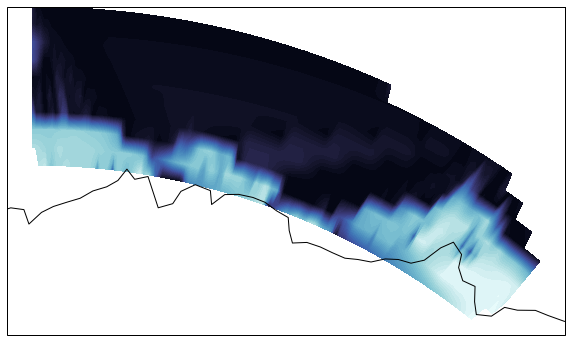

In [13]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=map_proj)
ax.contourf(xi, yi, grid_cheat, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
ax.coastlines()

# Final remarks

We have seen that regridding can introduce artifacts that are not there using Delaunay triangulation. Taking advantage of the non-uniform grids' rectangular structure helps prevent this from happening. The inclusion of a land mask would help eliminate sea ice over land artifacts. I am considering adding a land mask in later iterations of the Argovis grid module that would take care of this. 

For gridded product comparison, regridding on the browser also provides a means to compare two separate grids, where one grid is interpolated using the coordinates of another. While useful, interpolation should be used with caution. Interpolation can introduce artifacts.

A final remark: regridding is a necessary step when making charts, but does add overhead for regridding. Though it is written in typescript, It may be faster to implement some or all of the nearest neighbor algorithm in another language like Rust or C++ and convert it over to Web Assembly. 

It has been a pleasure writing this article. I hope you find it useful, or at least entertaining!